In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [2]:
# Load data
data = pd.read_csv('normal_attack_27_01.csv', low_memory=False, header="infer")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33449 entries, 0 to 33448
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Time                   33449 non-null  float64
 1   Source                 33449 non-null  object 
 2   Destination            33449 non-null  object 
 3   Protocol               33449 non-null  object 
 4   Length                 33449 non-null  int64  
 5   tcp.seq                25268 non-null  float64
 6   tcp.ack                25268 non-null  float64
 7   tcp.len                25268 non-null  float64
 8   tcp.window_size_value  25268 non-null  float64
 9   tcp.stream             25268 non-null  float64
 10  tcp.flags.syn          25268 non-null  object 
 11  tcp.flags.ack          25268 non-null  object 
 12  tcp.flags.fin          25268 non-null  object 
 13  tcp.flags.reset        25268 non-null  object 
 14  tcp.time_delta         25268 non-null  float64
 15  tc

In [4]:
# convert string in to 0 and 1's
data[[
    "tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.reset",
    "Protocol"
]] = data[[
    "tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.reset",
    "Protocol"
]].astype(str)
data["tcp.flags.syn.bin"] = data["tcp.flags.syn"].map({"Set": 1, "Not set": 0})
data["tcp.flags.ack.bin"] = data["tcp.flags.ack"].map({"Set": 1, "Not set": 0})
data["tcp.flags.fin.bin"] = data["tcp.flags.fin"].map({"Set": 1, "Not set": 0})
data["tcp.flags.reset.bin"] = data["tcp.flags.reset"].map({"Set": 1,"Not set": 0})

# Filter data
data = data[(data['Protocol'] == 'SSHv2') | (data['Protocol'] == 'TCP')]

# map also SSH vs TCP
data["Protocol.bin"] = data["Protocol"].map({"SSHv2": 1, "TCP": 0})

# Create a logical vector indicating whether each column is numeric
is_numeric = data.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x))
# Drop columns that are not numeric
df_filtered = data.loc[:, is_numeric]
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25268 entries, 0 to 25267
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Time                   25268 non-null  float64
 1   Length                 25268 non-null  int64  
 2   tcp.seq                25268 non-null  float64
 3   tcp.ack                25268 non-null  float64
 4   tcp.len                25268 non-null  float64
 5   tcp.window_size_value  25268 non-null  float64
 6   tcp.stream             25268 non-null  float64
 7   tcp.time_delta         25268 non-null  float64
 8   tcp.dstport            25268 non-null  float64
 9   tcp.flags.syn.bin      25268 non-null  int64  
 10  tcp.flags.ack.bin      25268 non-null  int64  
 11  tcp.flags.fin.bin      25268 non-null  int64  
 12  tcp.flags.reset.bin    25268 non-null  int64  
 13  Protocol.bin           25268 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 2.7 MB


In [6]:
filtered_data = df_filtered

# Reset the index for consistency
filtered_data = filtered_data.reset_index(drop=True)

# Filter data by 'time' variable for attack data (between 960 and 1062)

attack_list = []
for i in filtered_data["Time"]:
    if (960 <= i <= 1062):
        attack_list.append(1)
    else:
        attack_list.append(0)

# Add labels to the final filtered dataset
#filtered_data['label'] = attack_list

print(
    f"Proportion of normal and attack traffic: {sum(attack_list)/len(attack_list)}"
)
print(
    f"Proportion SSH: {sum(filtered_data["Protocol.bin"])/len(filtered_data["Protocol.bin"])}"
)

Proportion of normal and attack traffic: 0.22391958208010132
Proportion SSH: 0.47008073452588256


In [7]:
DF_dec_tree = filtered_data.drop(["Time", "tcp.dstport"], axis=1)
X_class = DF_dec_tree.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_class,  attack_list,  test_size=0.4,  random_state=1)

classifier = DecisionTreeClassifier(random_state=2, max_depth=4)
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7869
           1       0.98      1.00      0.99      2239

    accuracy                           0.99     10108
   macro avg       0.99      1.00      0.99     10108
weighted avg       0.99      0.99      0.99     10108



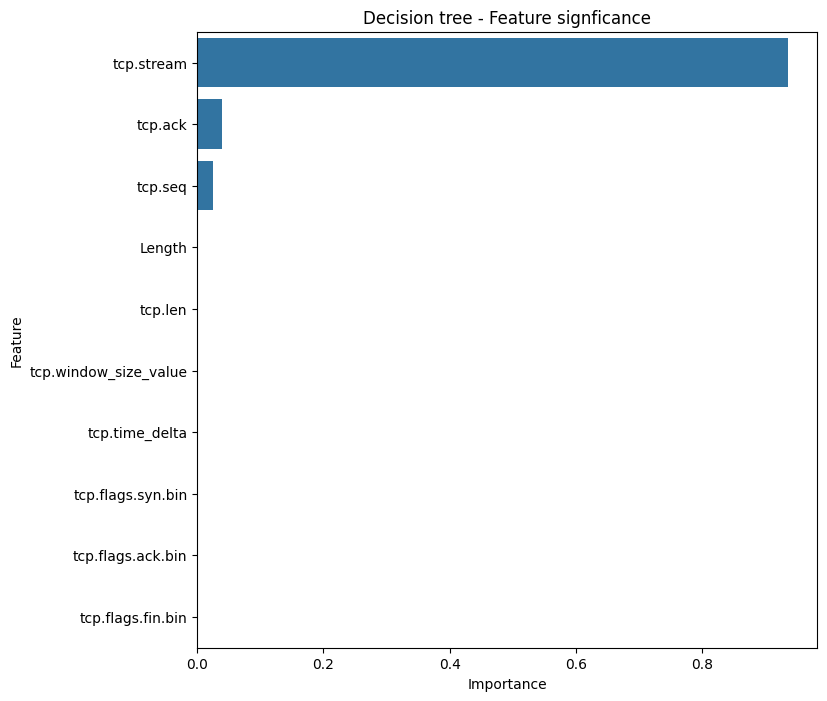

In [8]:
#extract the importance of each feature for the decision tree's predictions from best estimator
feature_importances = classifier.feature_importances_
features = [i for i in list(DF_dec_tree)]
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)
importance_df.head(10)

plt.figure(figsize=(8, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df[:][:10])
plt.title('Decision tree - Feature signficance')
plt.show()

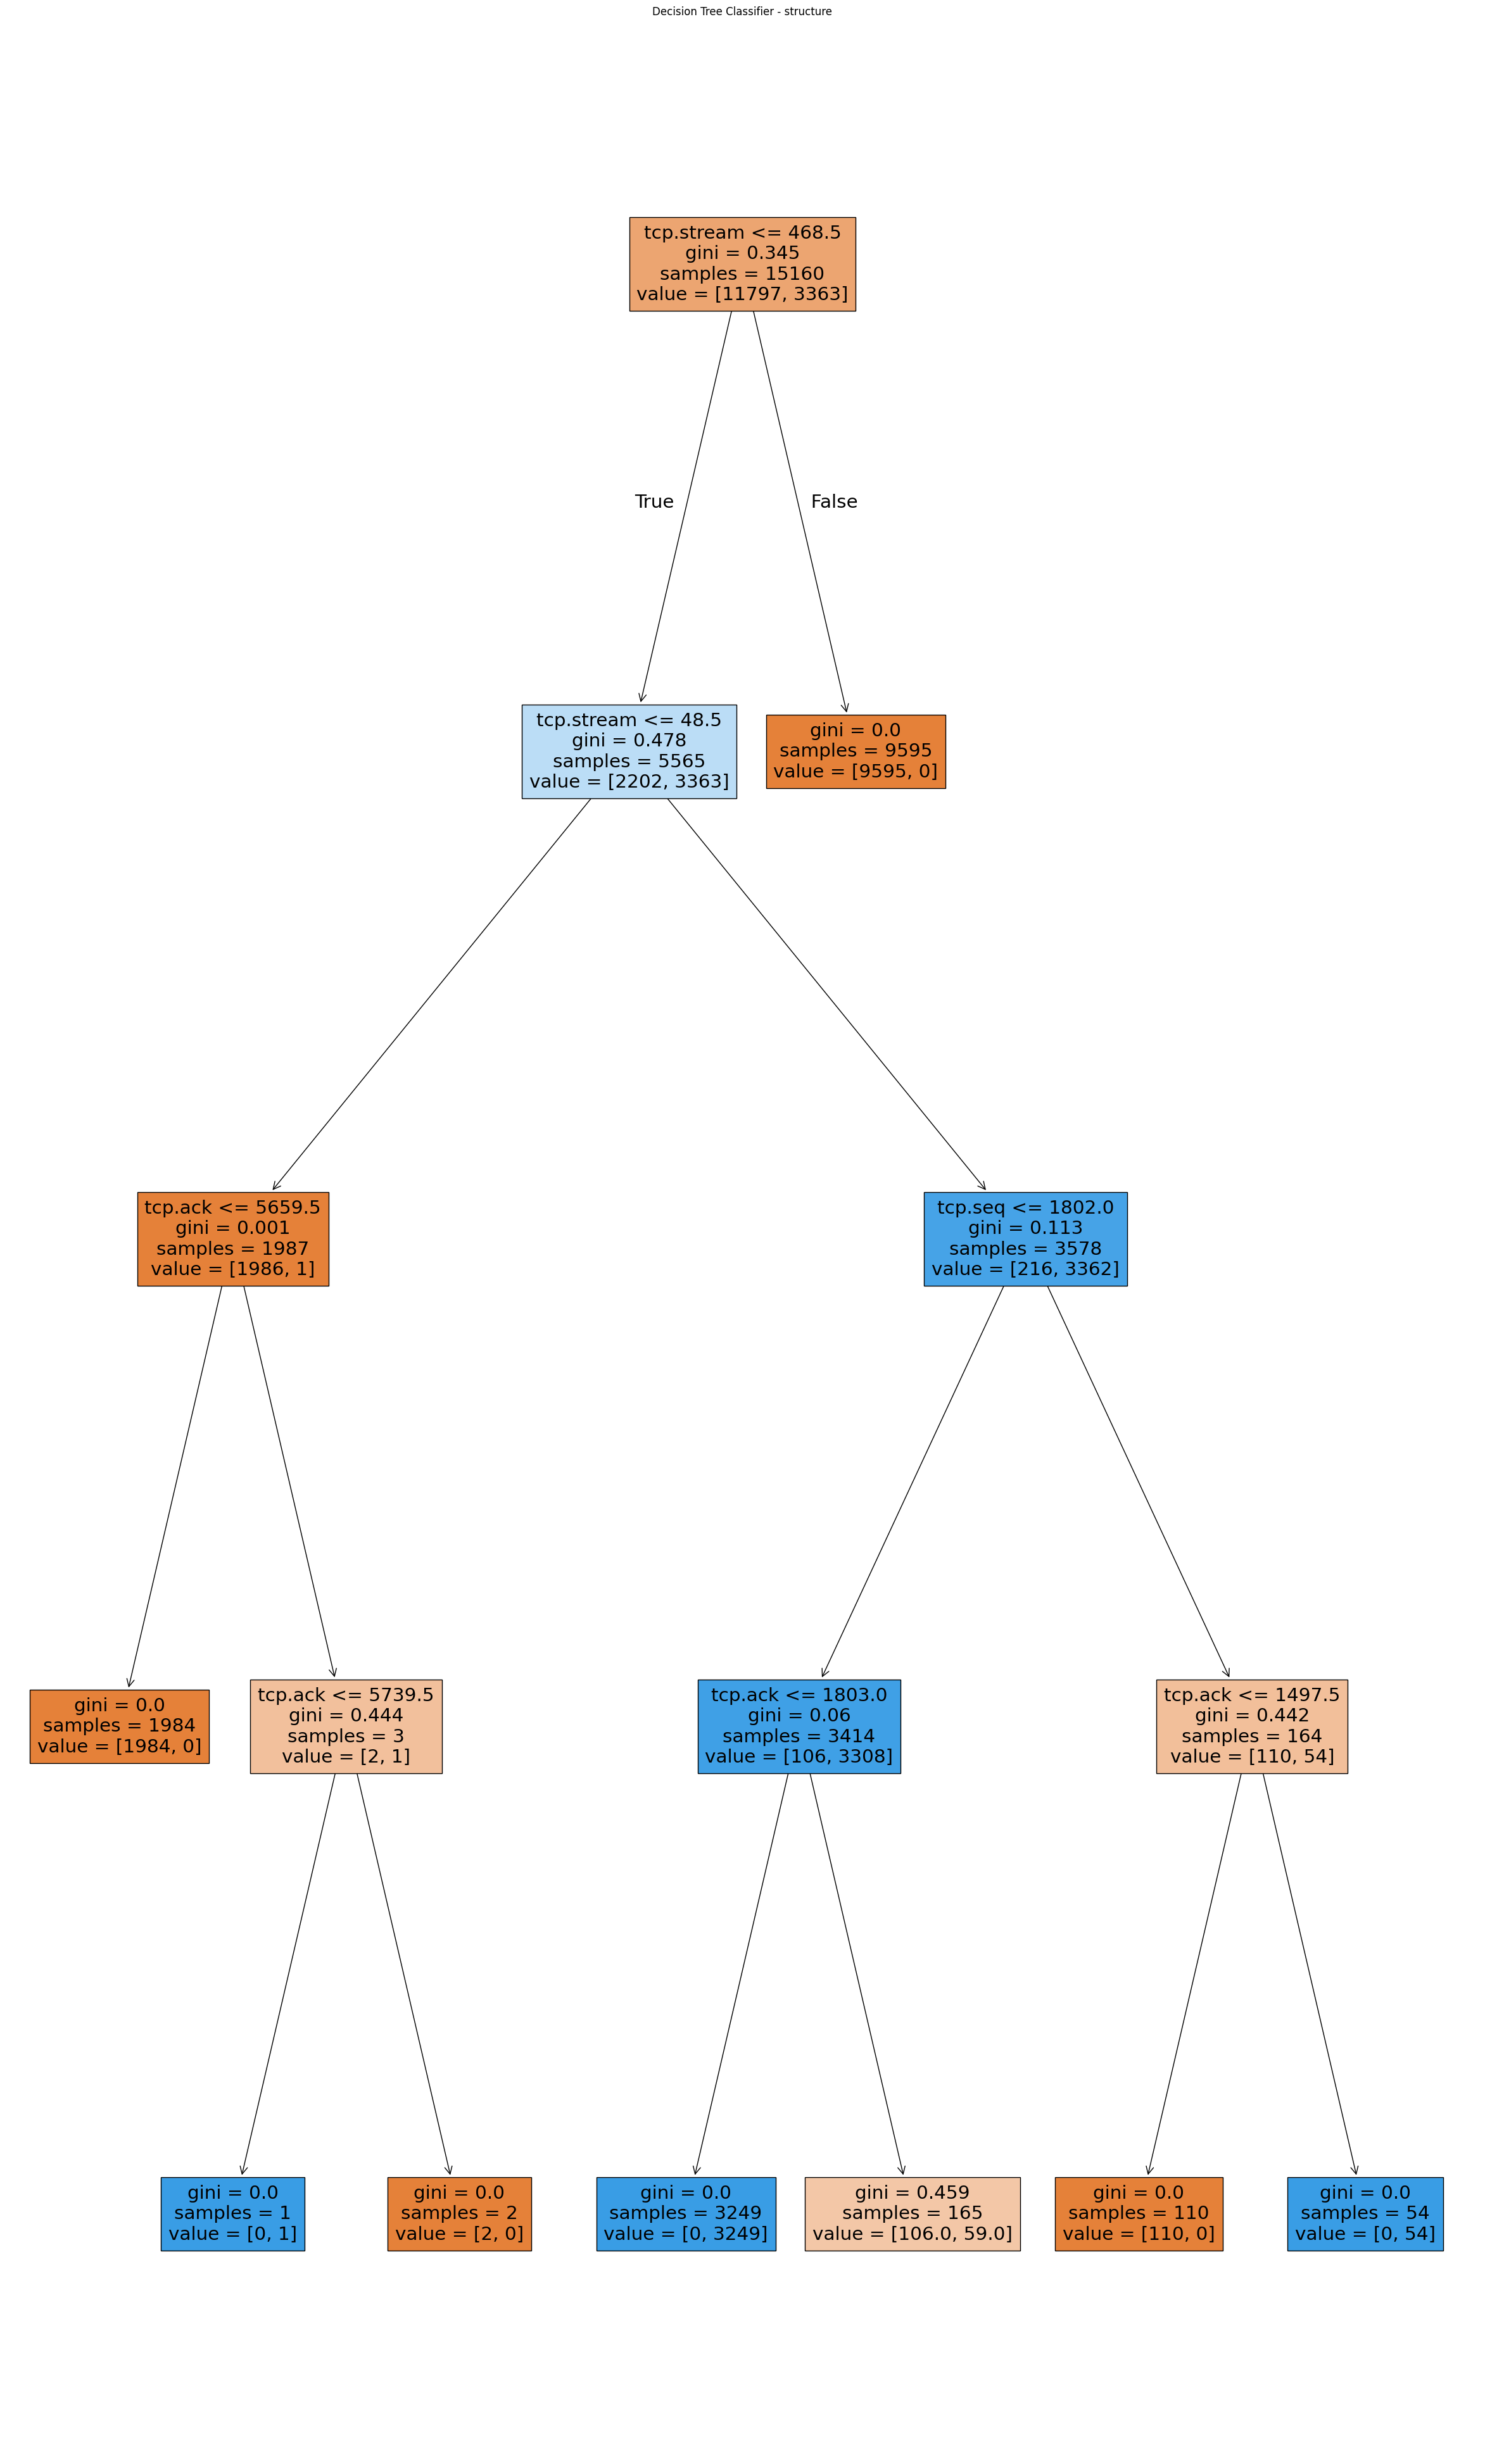

In [9]:
# Visualize the decision tree (optional)
features = [i for i in list(DF_dec_tree)]
plt.figure(figsize=(30, 50))
plot_tree(classifier, feature_names=features, filled=True)
plt.title('Decision Tree Classifier - structure')
plt.show()

In [11]:
# Perform cross-validation
from sklearn.model_selection import RepeatedKFold
RKF = RepeatedKFold(n_splits = 5, n_repeats = 5, random_state=0)
cv_scores = cross_val_score(classifier, X_class, attack_list, cv=RKF, scoring='accuracy')

# compute the avg accuracy and std
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
print(f'On average the cross-validated Accuracy is {cv_mean} with std {cv_std}')

On average the cross-validated Accuracy is 0.9932801046540232 with std 0.0017134809427554185


In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

In [14]:
# Set the number of cores to use (e.g., 4)
os.environ['LOKY_MAX_CPU_COUNT'] = '5'

# Preprocessing: Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(DF_dec_tree)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_scaled)

# Get cluster labels
pred_labels = kmeans.labels_
flipped_pred_labels = [1 - x for x in pred_labels]

#accuracy
print(classification_report(attack_list, flipped_pred_labels))

              precision    recall  f1-score   support

           0       0.78      0.56      0.65     19610
           1       0.23      0.47      0.31      5658

    accuracy                           0.54     25268
   macro avg       0.51      0.51      0.48     25268
weighted avg       0.66      0.54      0.58     25268



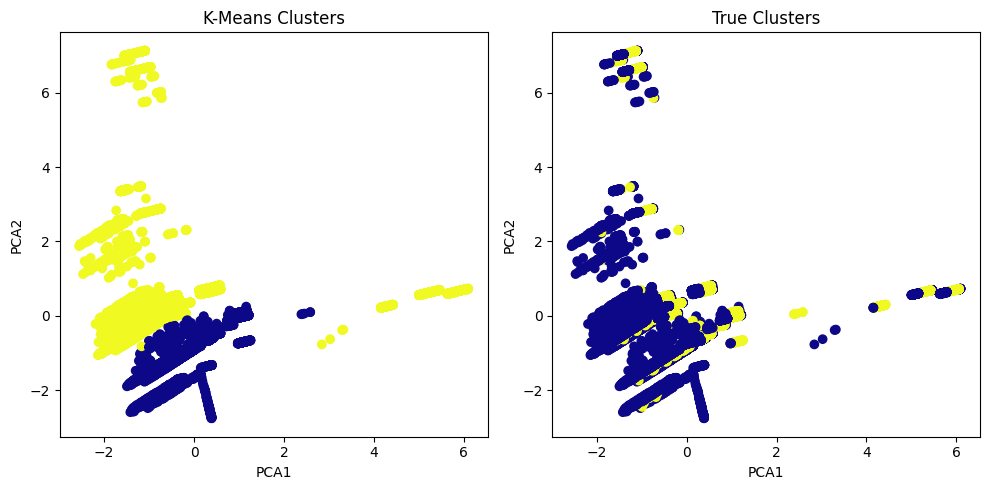

In [15]:
#visualise with PCA
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(data_scaled)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

# Plot for K-Means clusters
axes[0].scatter(reduced_features[:, 0], reduced_features[:, 1], c=pred_labels, cmap='plasma')
axes[0].set_title('K-Means Clusters')
axes[0].set_xlabel('PCA1')
axes[0].set_ylabel('PCA2')

# Plot for True clusters
axes[1].scatter(reduced_features[:, 0], reduced_features[:, 1], c=attack_list, cmap='plasma')
axes[1].set_title('True Clusters')
axes[1].set_xlabel('PCA1')
axes[1].set_ylabel('PCA2')

plt.tight_layout()
plt.show()

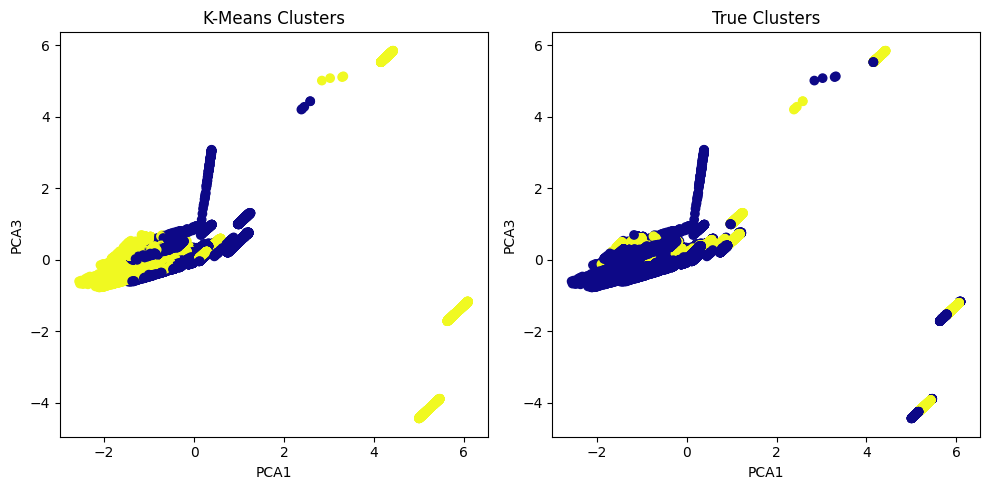

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

# Plot for K-Means clusters
axes[0].scatter(reduced_features[:, 0], reduced_features[:, 2], c=pred_labels, cmap='plasma')
axes[0].set_title('K-Means Clusters')
axes[0].set_xlabel('PCA1')
axes[0].set_ylabel('PCA3')

# Plot for True clusters
axes[1].scatter(reduced_features[:, 0], reduced_features[:, 2], c=attack_list, cmap='plasma')
axes[1].set_title('True Clusters')
axes[1].set_xlabel('PCA1')
axes[1].set_ylabel('PCA3')

plt.tight_layout()
plt.show()